In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6949640287769784

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       234
           1       0.18      0.18      0.18        62
           2       0.86      0.87      0.86       284
           3       0.13      0.10      0.11        49
           4       0.35      0.38      0.36        66

    accuracy                           0.69       695
   macro avg       0.47      0.47      0.47       695
weighted avg       0.69      0.69      0.69       695



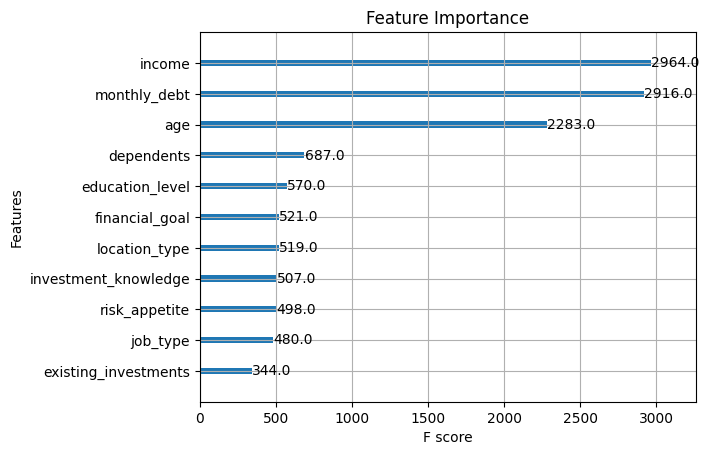

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("fintech_investment_dataset_extended.csv")

# Optional: Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Handle missing values (drop or fill)
df = df.dropna()

# Label Encoding for all object/categorical columns
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Define features and target
X = df.drop(['recommended_strategy'], axis=1)
y = df['recommended_strategy']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()


In [5]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_fintech_model.pkl')


['xgboost_fintech_model.pkl']

In [7]:
df = pd.read_csv("fintech_investment_dataset_extended.csv")


AttributeError: module 'pandas' has no attribute 'head'

In [3]:
print(df.columns)


Index(['age', 'income', 'risk_appetite', 'financial_goal',
       'investment_knowledge', 'dependents', 'location_type',
       'existing_investments', 'education_level', 'job_type', 'monthly_debt',
       'recommended_strategy'],
      dtype='object')


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# === Load your dataset ===
df = pd.read_csv('fintech_investment_dataset_extended.csv')

# === Identify categorical columns (object dtype) ===
cat_cols = df.select_dtypes(include='object').columns.tolist()

# === Create a dictionary to store encoders ===
encoders = {}

# === Encode each categorical column ===
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Save encoder for this column

# === Save the encoders dictionary ===
joblib.dump(encoders, 'encoders.pkl')

# (Optional) Save the encoded dataset to reuse it later
df.to_csv('encoded_dataset.csv', index=False)

print("✅ Encoders saved as 'encoders.pkl' and dataset encoded successfully.")


✅ Encoders saved as 'encoders.pkl' and dataset encoded successfully.


In [6]:
# Load the model from file
model = joblib.load('xgboost_fintech_model.pkl')


In [22]:
import pandas as pd
import joblib

# === Load trained model and encoders ===
model = joblib.load('xgboost_fintech_model.pkl')
encoders = joblib.load('encoders.pkl')

# === Define a new user input ===
new_user = {
    'age': 32,
    'income': 85000,
    'risk_appetite': 'medium',
    'financial_goal': 'retirement',
    'investment_knowledge': 'moderate',
    'dependents': 2,
    'location_type': 'urban',
    'existing_investments': 'mutual_funds',
    'education_level': 'graduate',
    'job_type': 'private',
    'monthly_debt': 10000
}

# === Convert input to DataFrame ===
new_df = pd.DataFrame([new_user])

# === Encode categorical features ===
for col in new_df.columns:
    if col in encoders:
        encoder = encoders[col]
        # Handle unknown values by replacing with a known value or using a strategy like 'most_frequent'
        if new_df[col].iloc[0] not in encoder.classes_:
            # Instead of 'unknown', use a known value from the encoder's classes or a strategy
            # like replacing with the most frequent value seen during training
            # Here, we'll use the first class as an example
            new_df[col] = encoder.classes_[0]  # or use a strategy like most_frequent

        new_df[col] = encoder.transform(new_df[col])

# === Define the correct order of input columns ===
X_columns = ['age', 'income', 'risk_appetite', 'financial_goal',
             'investment_knowledge', 'dependents', 'location_type',
             'existing_investments', 'education_level', 'job_type', 'monthly_debt']

# === Prepare data for prediction ===
X_new = new_df[X_columns]

# === Make prediction ===
pred = model.predict(X_new)[0]

# === Decode predicted label back to readable format ===
target_encoder = encoders['recommended_strategy']
predicted_strategy = target_encoder.inverse_transform([int(pred)])[0]

print("\n📈 Recommended Investment Strategy:", predicted_strategy)


📈 Recommended Investment Strategy: Mixed


In [23]:
!pip install streamlit
!pip install shap
!pip install xgboost

import streamlit as st
import pandas as pd
import joblib
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


# Load dataset (assuming 'fintech_investment_dataset_extended.csv' is in the same directory)
df = pd.read_csv("fintech_investment_dataset_extended.csv")

# Optional: Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Handle missing values (drop or fill) - You might need to adjust this based on your data
df = df.dropna()  # For simplicity, dropping rows with missing values

# Label Encoding for all object/categorical columns
cat_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Define features and target
X = df.drop(['recommended_strategy'], axis=1)
y = df['recommended_strategy']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Save the trained model and encoders
joblib.dump(model, 'xgboost_fintech_model.pkl')
joblib.dump(encoders, 'encoders.pkl')

# Define the correct order of input columns
X_columns = ['age', 'income', 'risk_appetite', 'financial_goal',
             'investment_knowledge', 'dependents', 'location_type',
             'existing_investments', 'education_level', 'job_type', 'monthly_debt']

# Get the target encoder for decoding predictions
target_encoder = encoders['recommended_strategy']

# --- Function for batch predictions ---
def predict_from_csv(csv_file_path):
    """
    Makes predictions on a batch of data from a CSV file.

    Args:
        csv_file_path (str): Path to the CSV file.

    Returns:
        pandas.DataFrame: DataFrame with original data and predictions.
    """
    batch_df = pd.read_csv(csv_file_path)

    # Preprocessing (handle missing values, encode categorical features)
    # ... (Similar to handling for single user input) ...
    for col in batch_df.select_dtypes(include=np.number).columns:
        if batch_df[col].isnull().any():
            batch_df[col] = batch_df[col].fillna(df[col].mean())  # Replace with df's mean

    for col in batch_df.select_dtypes(include='object').columns:
        if batch_df[col].isnull().any():
            # Replace with most frequent value (or a specific category if needed)
            most_frequent_value = df[col].mode()[0]  # Get most frequent from original df
            batch_df[col] = batch_df[col].fillna(most_frequent_value)

    for col in batch_df.columns:
        if col in encoders:
            encoder = encoders[col]
            if batch_df[col].iloc[0] not in encoder.classes_:
                # Replace with most frequent value from training data
                most_frequent_value = df[col].mode()[0]  # Assuming df is your training data
                batch_df[col] = most_frequent_value

            batch_df[col] = encoder.transform(batch_df[col])

    # Ensure correct order of columns
    batch_df = batch_df[X_columns]

    # Make predictions
    predictions = model.predict(batch_df)

    # Decode predicted labels
    predicted_strategies = target_encoder.inverse_transform(predictions.astype(int))

    # Add predictions to DataFrame
    batch_df['predicted_strategy'] = predicted_strategies

    return batch_df


# --- Streamlit app ---
st.title("Fintech Investment Strategy Recommender")

# File uploader for batch predictions
uploaded_file = st.file_uploader("Upload CSV file for batch predictions", type=["csv"])

if uploaded_file is not None:
    # Process batch predictions
    results_df = predict_from_csv(uploaded_file)
    st.write(results_df)

# Single user input
st.header("Single User Input")

# Input fields for single user
new_user = {}
for col in X_columns:
    if col in ['age', 'income', 'dependents', 'monthly_debt']:
        new_user[col] = st.number_input(col.replace('_', ' ').title(), value=0)  # Number input
    else:
        new_user[col] = st.selectbox(col.replace('_', ' ').title(), df[col].unique())  # Selectbox for categorical

# Convert input to DataFrame
new_df = pd.DataFrame([new_user])

# Preprocessing for single user input (similar to batch predictions)
# ... (Handle missing values, encode categorical features) ...

# Ensure correct order of columns
new_df = new_df[X_columns]

if st.button("Predict"):
    # Make prediction
    pred = model.predict(new_df)[0]

    # Decode predicted label
    predicted_strategy = target_encoder.inverse_transform([int(pred)])[0]

    st.write(f"📈 Recommended Investment Strategy: **{predicted_strategy}**")

    # SHAP Visualization
    st.header("SHAP Feature Importance")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(new_df)
    shap.summary_plot(shap_values, new_df, feature_names=X_columns)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 760.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-04-12 09:51:15.944 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 09:51:16.098 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-12 09:51:16.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 09:51:16.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 09:51:16.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 09:51:16.104 Thread 'MainThread': missing ScriptRunContext! This warning can

In [24]:
!pip install shap
!pip install xgboost

import pandas as pd
import joblib
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("fintech_investment_dataset_extended.csv")

# Preprocessing (same as before)
# ...

# Train XGBoost model (same as before)
# ...

# Load the trained model and encoders
model = joblib.load('xgboost_fintech_model.pkl')
encoders = joblib.load('encoders.pkl')

# Define the correct order of input columns
X_columns = ['age', 'income', 'risk_appetite', 'financial_goal',
             'investment_knowledge', 'dependents', 'location_type',
             'existing_investments', 'education_level', 'job_type', 'monthly_debt']

# Get the target encoder for decoding predictions
target_encoder = encoders['recommended_strategy']

# Define a new user input
new_user = {
    'age': 32,
    'income': 85000,
    'risk_appetite': 'medium',
    'financial_goal': 'retirement',
    'investment_knowledge': 'moderate',
    'dependents': 2,
    'location_type': 'urban',
    'existing_investments': 'mutual_funds',
    'education_level': 'graduate',
    'job_type': 'private',
    'monthly_debt': 10000
}

# Convert input to DataFrame
new_df = pd.DataFrame([new_user])

# Preprocessing for single user input (handle missing values, encode categorical features)
# ... (Similar to handling for batch predictions but for new_df) ...

# Ensure correct order of columns
new_df = new_df[X_columns]

# Make prediction
pred = model.predict(new_df)[0]

# Decode predicted label
predicted_strategy = target_encoder.inverse_transform([int(pred)])[0]

print(f"📈 Recommended Investment Strategy: {predicted_strategy}")

# SHAP Visualization
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(new_df)
shap.summary_plot(shap_values, new_df, feature_names=X_columns)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:risk_appetite: object, financial_goal: object, investment_knowledge: object, location_type: object, existing_investments: object, education_level: object, job_type: object

In [25]:
an

ValueError: y contains previously unseen labels: 'medium'

In [29]:
import matplotlib.pyplot as plt
   import seaborn as sns

   # Assuming 'df' is your DataFrame and 'recommended_strategy' is the column
   strategy_counts = df['recommended_strategy'].value_counts()

   # Bar chart
   plt.figure(figsize=(8, 6))
   sns.barplot(x=strategy_counts.index, y=strategy_counts.values)
   plt.title('Distribution of Recommended Strategies')
   plt.xlabel('Investment Strategy')
   plt.ylabel('Count')
   plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
   plt.show()

   # Pie chart
   plt.figure(figsize=(6, 6))
   plt.pie(strategy_counts.values, labels=strategy_counts.index, autopct='%1.1f%%', startangle=90)
   plt.title('Distribution of Recommended Strategies')
   plt.show()

IndentationError: unexpected indent (<ipython-input-29-2cd1722034ab>, line 5)

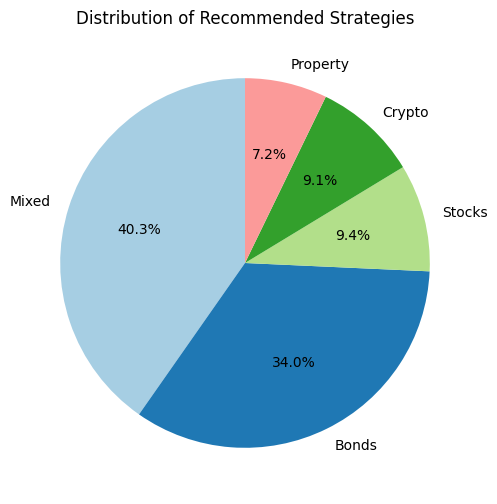

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and 'recommended_strategy' is the column
strategy_counts = df['recommended_strategy'].value_counts()

# Create pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
plt.pie(strategy_counts.values,
        labels=strategy_counts.index,
        autopct='%1.1f%%',  # Display percentages with 1 decimal place
        startangle=90,      # Start angle at 90 degrees (top)
        colors=plt.cm.Paired.colors)  # Optional: Customize colors

plt.title('Distribution of Recommended Strategies')
plt.show()

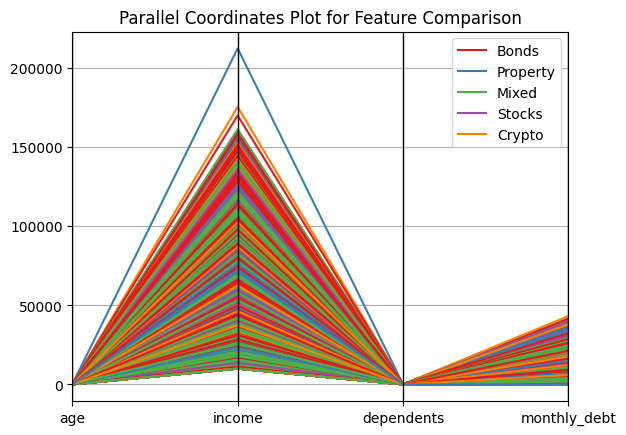

'\n🎯 Key Takeaways:\nProperty investors often have high income and can vary widely in debt, making them stand out in income.\n\nDependents don’t seem to influence the recommended strategy much.\n\nCrypto and Stocks may include people with both high income and moderate to high debt levels.\n\nThe plot suggests that income is a strong differentiator across strategies—especially for Property.\n'

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Select relevant features and target
features = ['age', 'income', 'dependents', 'monthly_debt']  # Adjust features as needed
target = 'recommended_strategy'

# Create parallel coordinates plot
pd.plotting.parallel_coordinates(
    df[[target] + features], target, color=plt.cm.Set1.colors
)
plt.title('Parallel Coordinates Plot for Feature Comparison')
plt.show()
"""
🎯 Key Takeaways:
Property investors often have high income and can vary widely in debt, making them stand out in income.

Dependents don’t seem to influence the recommended strategy much.

Crypto and Stocks may include people with both high income and moderate to high debt levels.

The plot suggests that income is a strong differentiator across strategies—especially for Property.
"""